In [31]:
#deps
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()

In [32]:
# read the data
data = pd.read_csv('data/mncs-players.csv')

# immediately drop problematic data (such as forfeits or data that is clearly incorrect)
data = data.dropna(subset=['team_id', 'map_name', 'team_color', 'opponent_team_color'])

C:\Users\Corbin\AppData\Local\Temp\ipykernel_12972\4000533265.py:2: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data/mncs-players.csv')


In [33]:
# find out where data is missing
missing_data = data.isnull().sum()
print(missing_data[missing_data > 0])

game_id_overtime_game      28074
match_id_win               17586
game_id_win                17586
game_id_win_total          17586
game_id_forfeit_win        35172
overtime_seconds_played    28074
ms_most_forward                1
is_sub_for_team            31052
dtype: int64


In [34]:
# null handling
true_false_cols = ['is_sub_for_team', 'game_id_overtime_game', 'overtime_seconds_played',
                   'match_id_win', 'game_id_win']
for c in true_false_cols:
    if c in data.columns:
        data[c] = data[c].notnull()
data['overtime_seconds_played'] = data['overtime_seconds_played'].fillna(0)

# drop useless columns
useless_columns = ['league_name', 'map_name', 'game_id_total',
                   'team_name', 'opponent_team_name','game_id_forfeit_win',
                   'game_id_win_total', 'season_id', 'match_type', 'epoch_processed',
                   'week', 'game_id_win', 'games_played', 'match_id']
for c in useless_columns:
    if c in data.columns:
        data = data.drop(c, axis=1)

In [35]:
# days from Jan 1, 2019, when the league started
# Convert the date column to datetime and make it tz-naive
data['game_date'] = pd.to_datetime(data['game_date']).dt.tz_convert(None)

# Define the date to subtract from
date_to_subtract = pd.to_datetime('2019-01-01')

# Calculate the number of days difference and assign to the date column
data['game_date'] = (data['game_date'] - date_to_subtract).dt.days

In [36]:
# Check for null values
null_like = [np.nan, None, [], {}, 'NaN', 'Null','NULL','None','NA','?','-', '.', '', ' ', '   ']

print("Property | isnull() | null-like")
for c in data.columns:
    string_null = np.array([x in null_like for x in data[c]])
    null_sum = string_null.sum()
    if null_sum > 0:
        print(c, null_sum)

Property | isnull() | null-like


In [37]:
print('sum', data.isna().sum().sum())

sum 1


In [38]:
# found 1 na so we drop it
data = data.dropna()

In [39]:
object_columns = data.dtypes[data.dtypes == 'object'].index
print(object_columns)
for column in object_columns:
    print(f"{column}:\n{data[column].head()}\n")

Index(['league_id', 'game_id', 'player_id', 'player_name', 'player_platform',
       'player_platform_id', 'team_id', 'opponent_team_id', 'team_color',
       'opponent_team_color'],
      dtype='object')
league_id:
0    5ec9359b8c0dd900074686d3
1    5ec9359b8c0dd900074686d3
2    5ec9359b8c0dd900074686d3
3    5ec9359b8c0dd900074686d3
4    5ec9359b8c0dd900074686d3
Name: league_id, dtype: object

game_id:
0    621b06d35e639700090d6a47
1    621b06d35e639700090d6a47
2    621b06d35e639700090d6a47
3    621b06d35e639700090d6a45
4    621b06d35e639700090d6a45
Name: game_id, dtype: object

player_id:
0    60eb9cffce9d6800082487b5
1    5ec9358f8c0dd900074685c8
2    62081fc5660ef60009f505df
3    62081fc5660ef60009f505df
4    5ec9358f8c0dd900074685c8
Name: player_id, dtype: object

player_name:
0        ryker
1    IamGatman
2      Bouy101
3      Bouy101
4    IamGatman
Name: player_name, dtype: object

player_platform:
0    steam
1    steam
2     epic
3     epic
4    steam
Name: player_platform, dty

In [40]:
# print out the remaining columns
print('number of games', len(data.index))
for c in data.columns:
    print(c)

number of games 35171
league_id
season_name
game_id
game_date
game_number
game_id_overtime_game
match_id_win
player_id
player_name
player_platform
player_platform_id
team_id
opponent_team_id
team_color
opponent_team_color
mvps
wins
ms_played
overtime_seconds_played
shots
shots_against
goals
goals_against
saves
assists
score
amount_collected
amount_stolen
amount_collected_big
amount_stolen_big
amount_collected_small
amount_stolen_small
count_collected_big
count_stolen_big
count_collected_small
count_stolen_small
amount_overfill
amount_overfill_stolen
amount_used_while_supersonic
ms_zero_boost
ms_full_boost
ms_boost_0_25
ms_boost_25_50
ms_boost_50_75
ms_boost_75_100
total_distance
ms_supersonic_speed
ms_boost_speed
ms_slow_speed
ms_ground
ms_low_air
ms_high_air
ms_powerslide
count_powerslide
avg_powerslide_duration
avg_distance_to_ball
avg_distance_to_ball_possession
avg_distance_to_ball_no_possession
avg_distance_to_mates
ms_defensive_third
ms_neutral_third
ms_offensive_third
ms_defensi

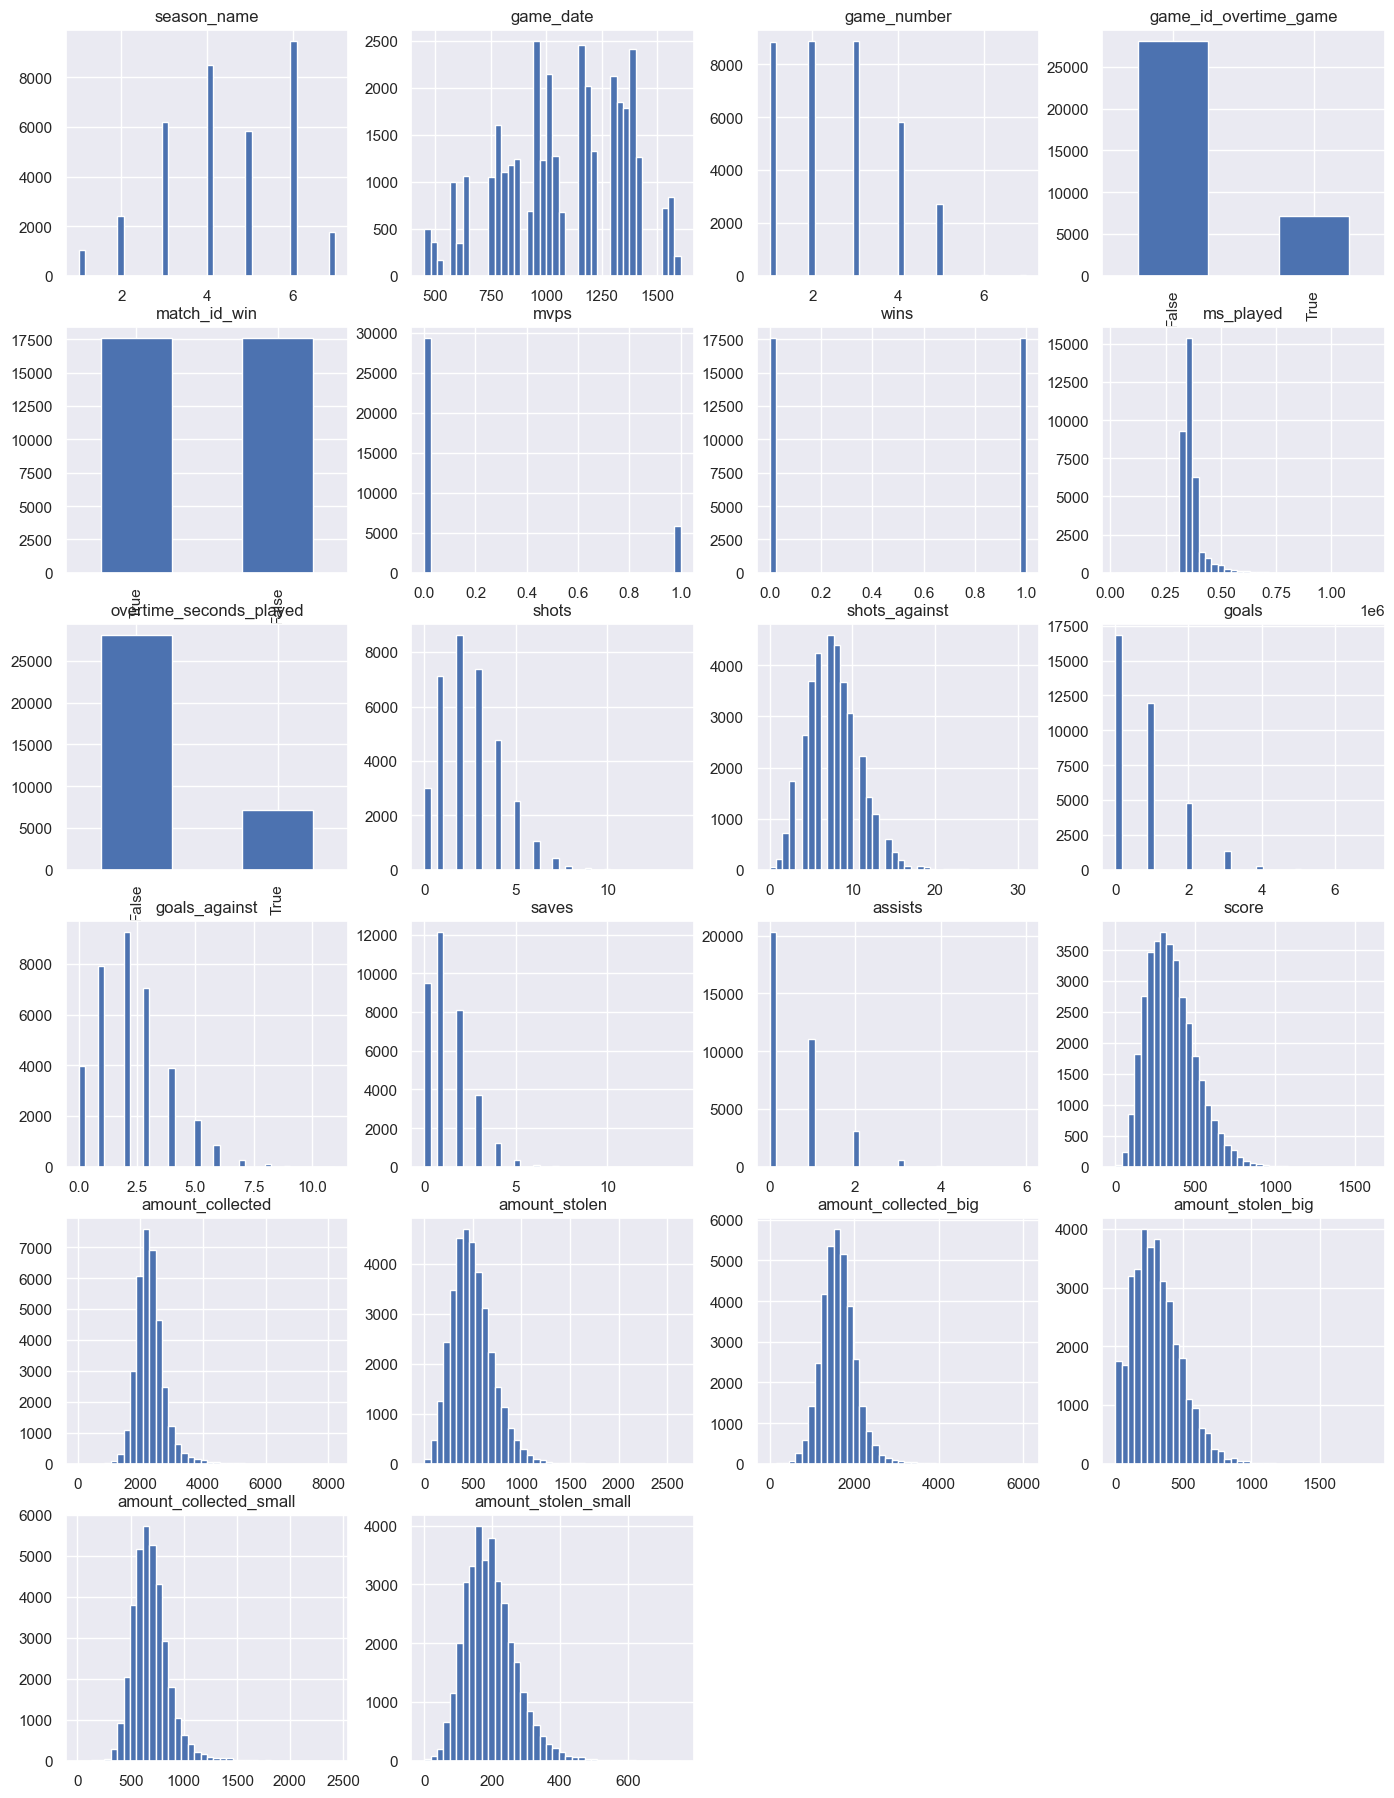

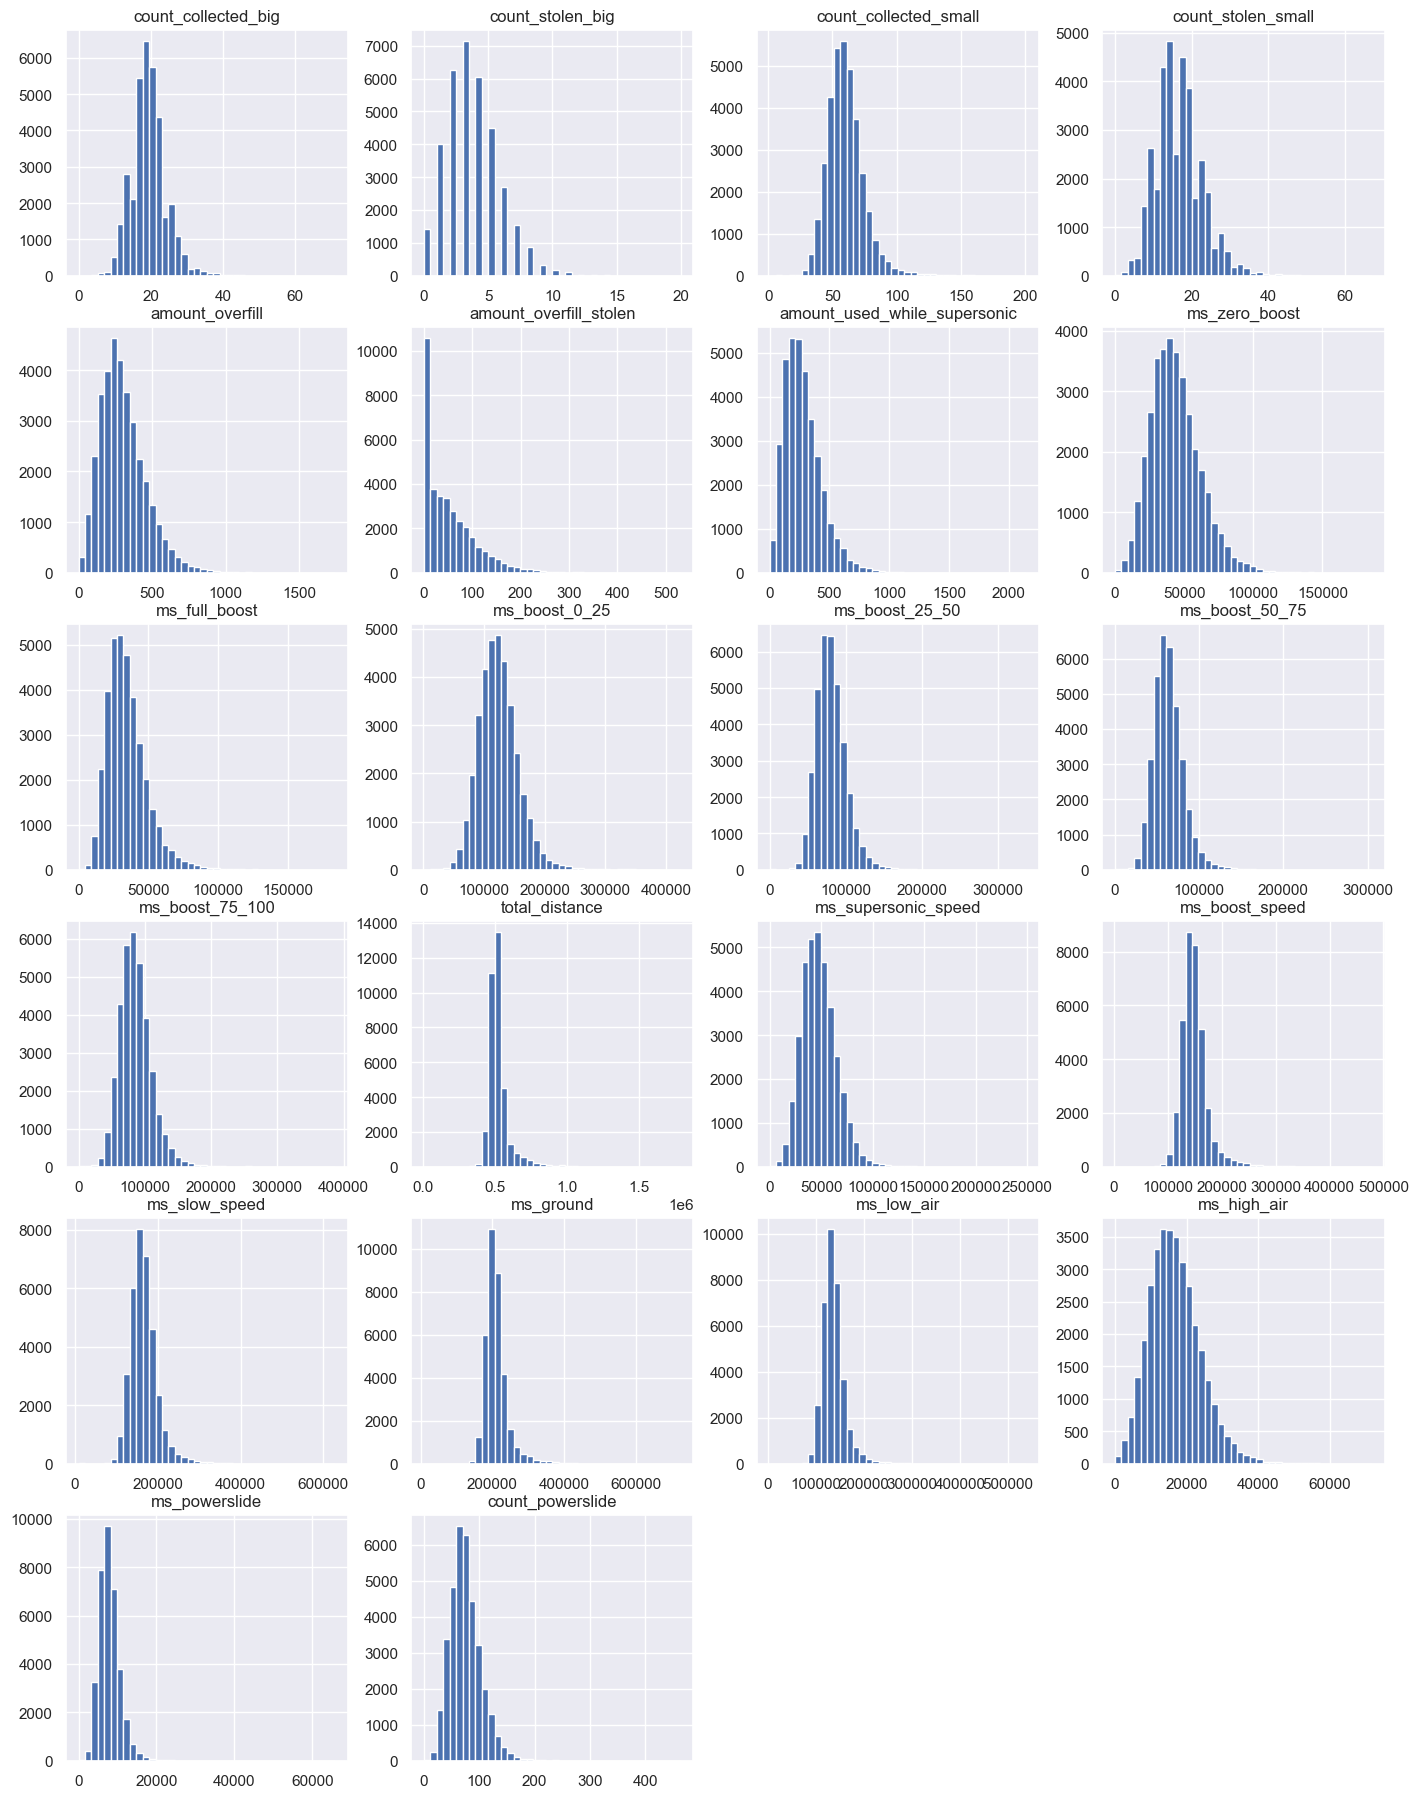

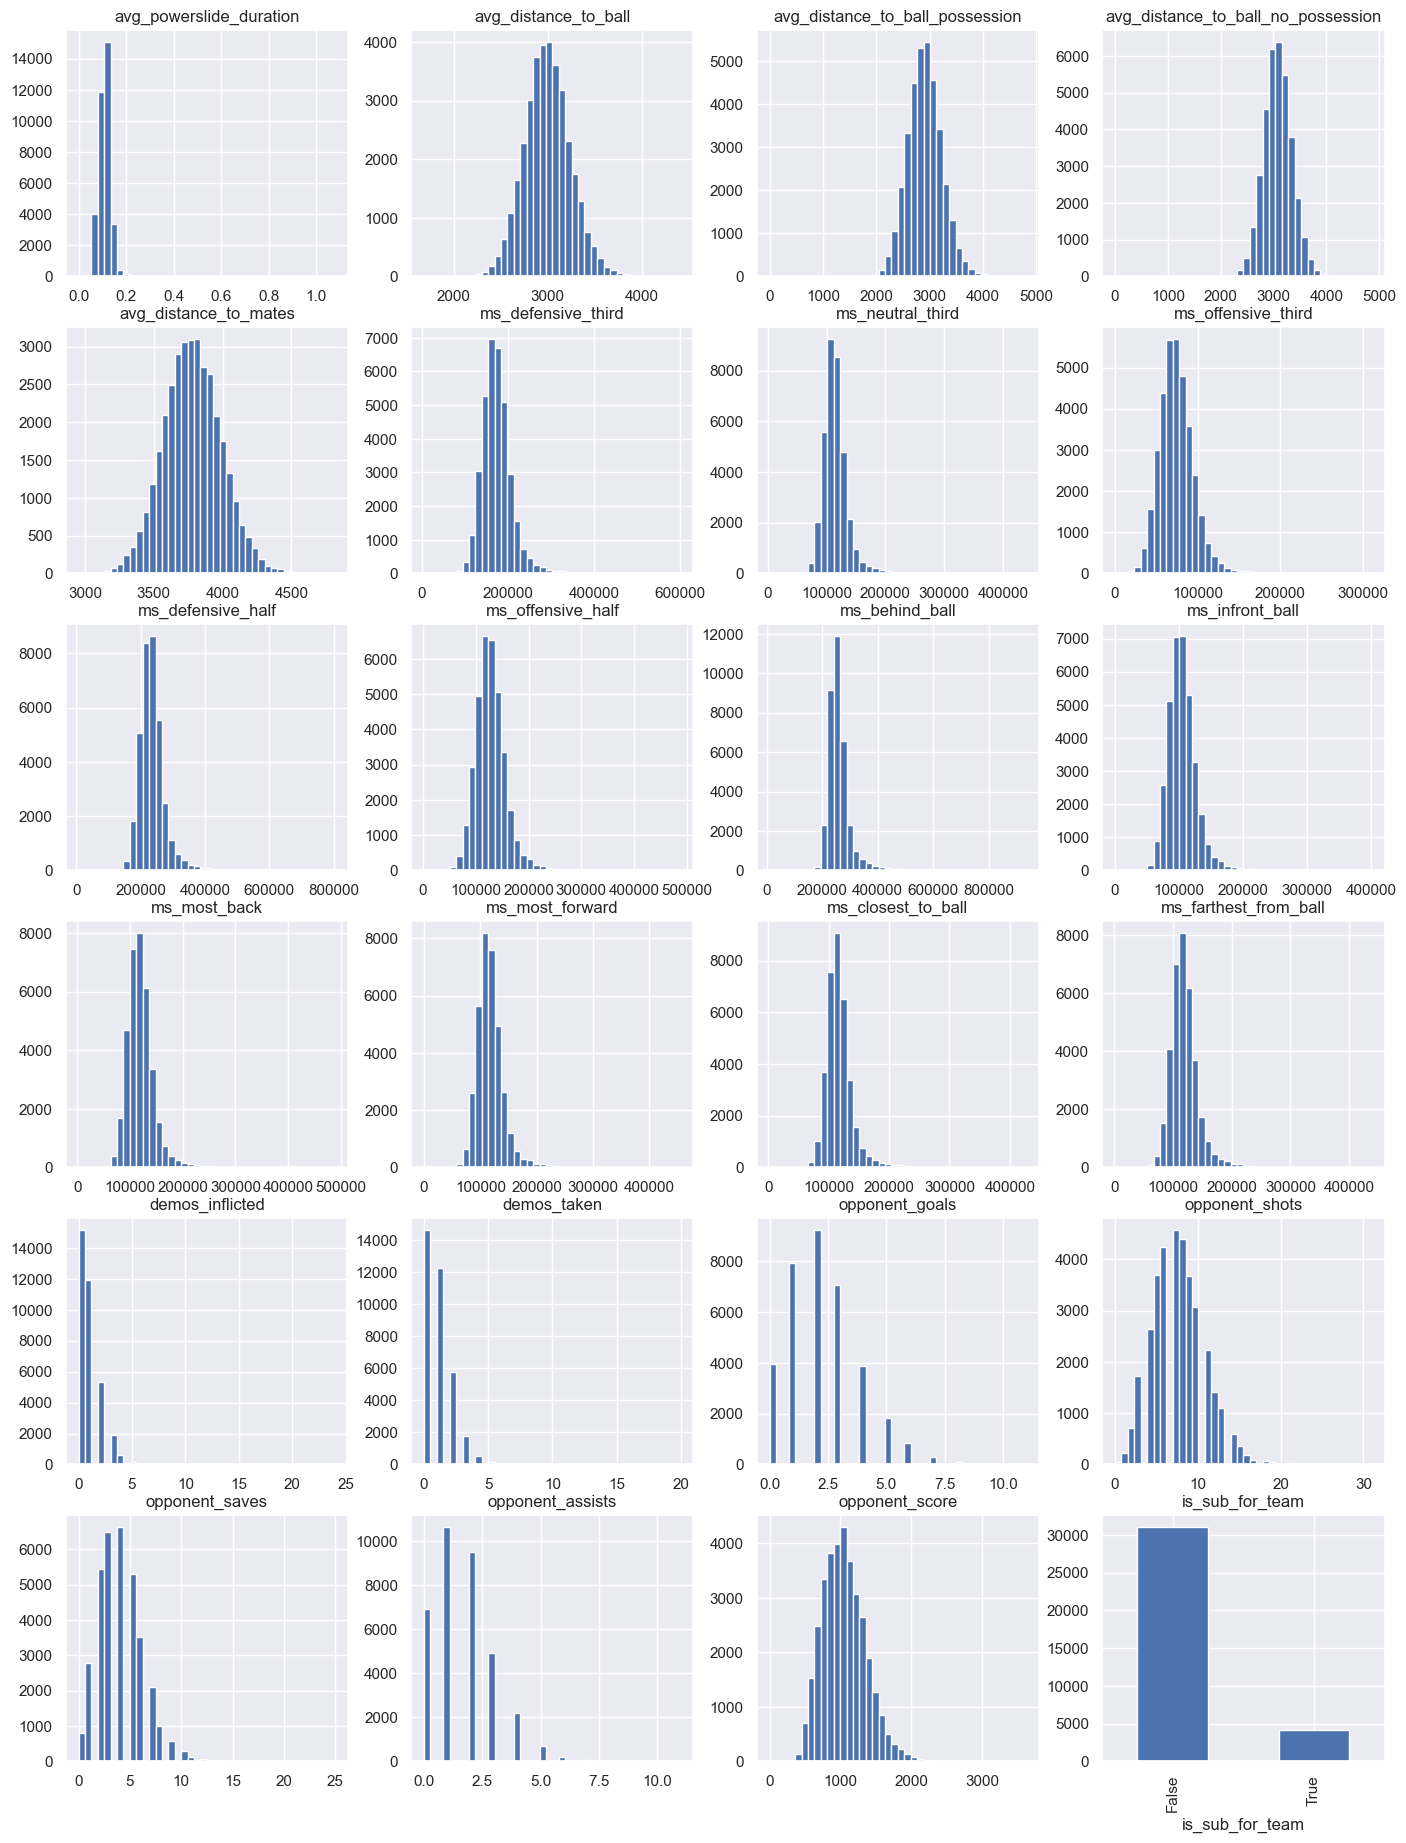

In [41]:
display_df = data.drop(object_columns, axis=1)
n = len(display_df.columns)
n_per_fig = n // 3  # calculate number of columns per figure

# Create three figures
for i in range(3):
    start = i * n_per_fig
    end = (i+1) * n_per_fig if i != 2 else None  # go to end for last figure
    columns = display_df.columns[start:end]
    
    rows = len(columns)//4 + (len(columns)%4 != 0)  # calculate number of rows necessary for 4 columns

    fig, a = plt.subplots(rows, 4, figsize=(14, 3*rows))  # adjust size as necessary
    fig.tight_layout()

    for j, c in enumerate(columns):
        dat = display_df[c]
        ax = a.flat[j]
        if display_df[c].dtype == 'bool':
            display_df[c].value_counts().plot(kind='bar', ax=ax)
            ax.set_title(c)
        else:
            ax.hist(dat, bins=40)
            ax.set_title(c)
        
    # Remove unused subplots
    if len(columns) < rows*4:
        for ax in a.flat[len(columns):]:
            ax.axis('off')

    plt.show()

<Axes: >

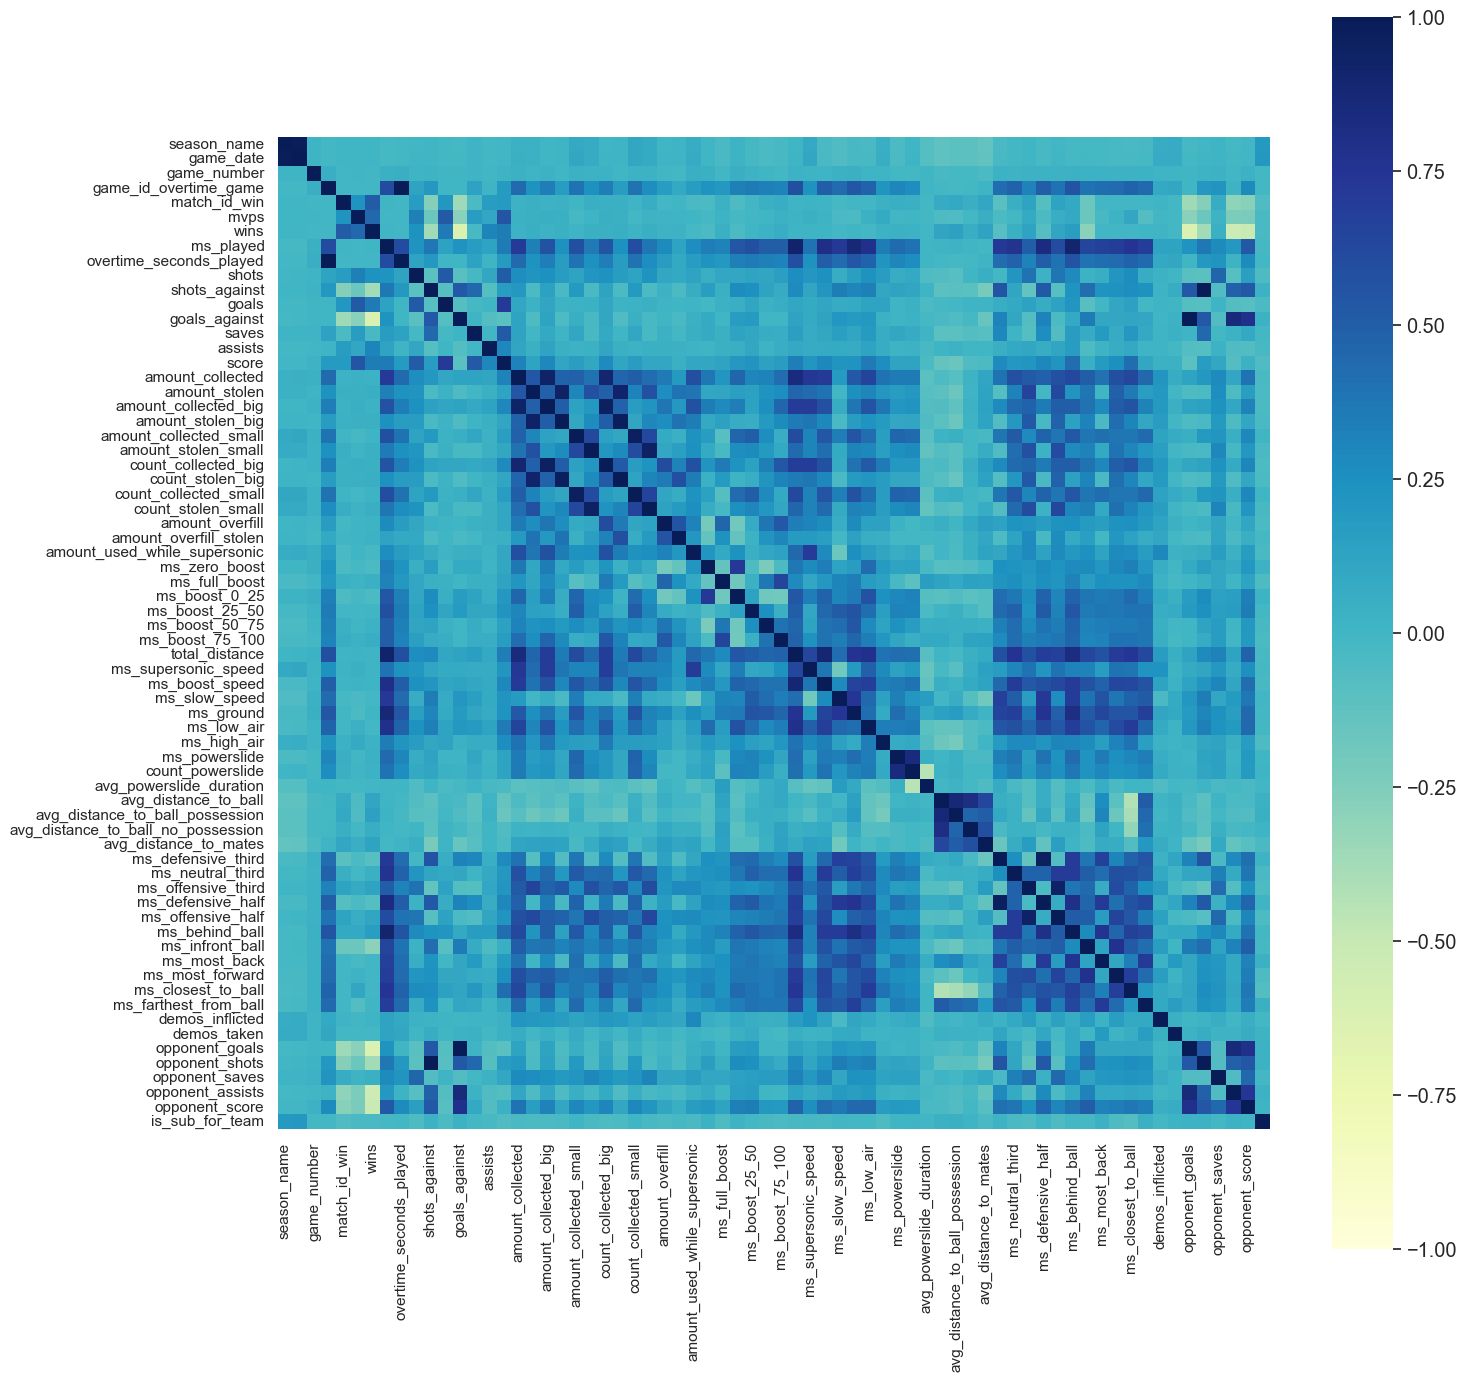

In [42]:
# Look into feature correlation
corr = display_df.corr()
plt.subplots(figsize=(16,16))
sns.set(font_scale=1.3)
sns.heatmap(data=corr, vmin=-1, vmax=1, cmap="YlGnBu", square=True, yticklabels=True)

None of the positive/negative correlations struck me too much by surprise. The negative correlation between `ms_infront_ball` and `wins` is the one I was most curious about. Practically, I wonder if that is due to the ball being "over the defenders' heads" a lot in games that they lost, or whether it would be due to an over-aggression getting teams into trouble.

I want to know if certain correlation paris (such as ms_infront_ball x wins) correlate differently for different players. The investigation below revealed a couple of interesting takeaways. One observation was that we needed to only look at players with a minimum number of games played to avoid huge outliers on charts. I picked 30, since that's the number of observations typically needed for statistical significance. The other is that `ms_infront_ball` is negative for every player in the league, for all of history.

I am curious, and may potentially investigate further, whether there are any fields that tend to be higher for premier players (or whether we could identify premier-caliber players more easily using a certain metric or combination of metrics).

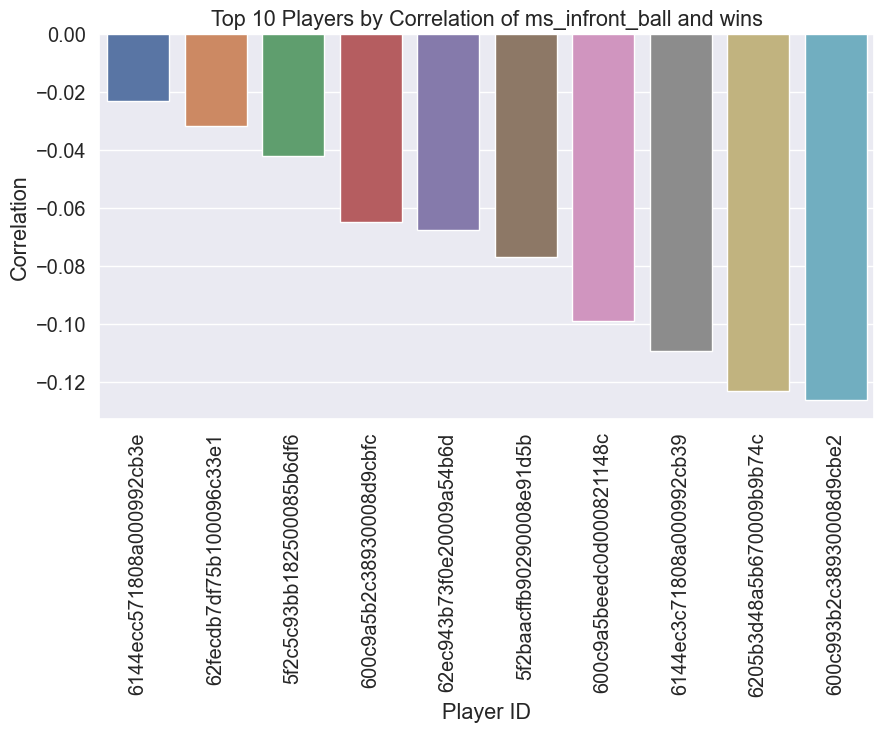

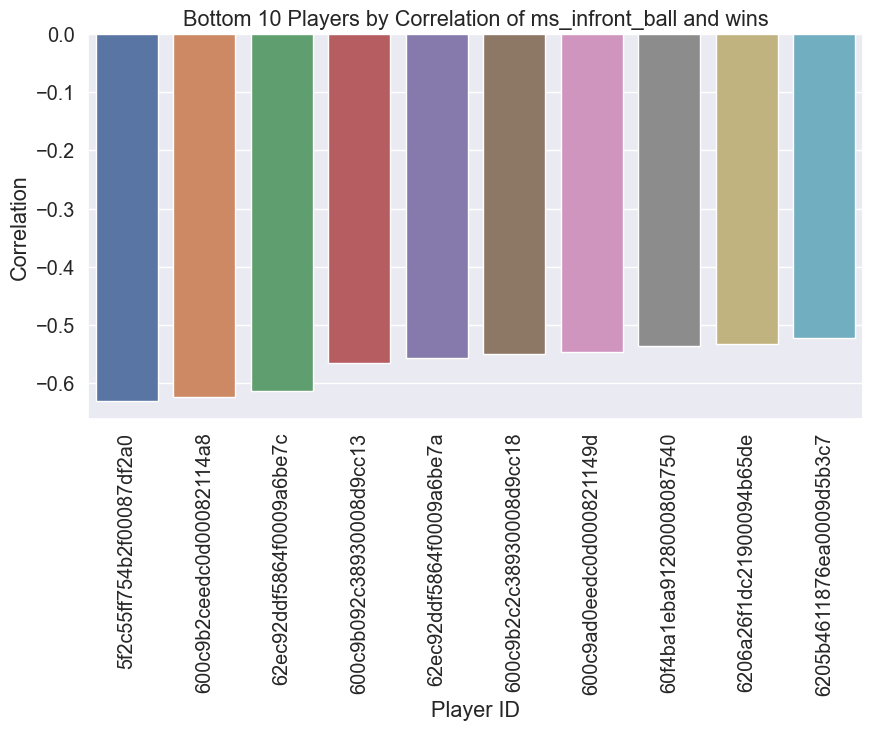

player_id
6144ecc571808a000992cb3e   -0.023225
62fecdb7df75b100096c33e1   -0.031932
5f2c5c93bb182500085b6df6   -0.042225
600c9a5b2c38930008d9cbfc   -0.065002
62ec943b73f0e20009a54b6d   -0.067569
5f2baacffb90290008e91d5b   -0.077125
600c9a5beedc0d000821148c   -0.098951
6144ec3c71808a000992cb39   -0.109497
6205b3d48a5b670009b9b74c   -0.123280
600c993b2c38930008d9cbe2   -0.126494
dtype: float64


In [43]:
# Filter player_ids with more than 30 records
players_with_enough_data = data.groupby('player_id').filter(lambda x: len(x) > 30)

# Calculate correlations for each player
player_correlations = players_with_enough_data.groupby('player_id').apply(lambda x: x['ms_infront_ball'].corr(x['wins']))

# Get top 10 and bottom 10 players by correlation
top_10_players = player_correlations.nlargest(10)
bottom_10_players = player_correlations.nsmallest(10)

# Plot top 10 players
plt.figure(figsize=(10,5))
sns.barplot(x=top_10_players.index, y=top_10_players.values)
plt.title('Top 10 Players by Correlation of ms_infront_ball and wins')
plt.xlabel('Player ID')
plt.ylabel('Correlation')
plt.xticks(rotation=90)
plt.show()

# Plot bottom 10 players
plt.figure(figsize=(10,5))
sns.barplot(x=bottom_10_players.index, y=bottom_10_players.values)
plt.title('Bottom 10 Players by Correlation of ms_infront_ball and wins')
plt.xlabel('Player ID')
plt.ylabel('Correlation')
plt.xticks(rotation=90)
plt.show()

print(top_10_players)

## Standard Deviations

In order to determine which columns might be best at predicting whether a player or combination of players will win or lose a game, I'd like to understand which columns have the lowest standard deviation. From there, I'll use that in model training to see if we can get a relatively reliable model.

For the sake of exploring the data, I'll also investigate which columns have the highest standard deviation.

In [66]:
# Calculate the standard deviation for each column for each player
object_columns = list(data.dtypes[data.dtypes == 'object'].index)
no_std_diff_cols = object_columns + ['is_sub_for_team', 'mvps']
print(data['game_id_overtime_game'])

player_stds_df = data[data['game_id_overtime_game'] != True]
player_stds_df = player_stds_df.drop([c for c in no_std_diff_cols if 'player_id' not in c], axis=1)
object_columns = player_stds_df.dtypes[data.dtypes == 'object'].index
player_stds = player_stds_df.groupby('player_id').std()

# Find the top 10 columns with the highest and lowest standard deviation for each player
player_max_std = player_stds.apply(lambda x: x.nlargest(10).index.tolist(), axis=1)
player_min_std = player_stds.apply(lambda x: x.nsmallest(10).index.tolist(), axis=1)

# Calculate the standard deviation for each column for the whole dataset
player_stds_df = player_stds_df.drop(columns=['player_id'], axis=1)
total_std = player_stds_df.std()

# Find the top 10 columns with the highest and lowest standard deviation in the dataset
total_max_std = total_std.nlargest(10).index.tolist()
total_min_std = total_std.nsmallest(10).index.tolist()

print("Columns with highest standard deviation per player:")
print(player_max_std)
print("\nColumns with lowest standard deviation per player:")
print(player_min_std)
print("\nColumns with highest standard deviation in total dataset:", total_max_std)
print("\nColumns with lowest standard deviation in total dataset:", total_min_std)

Columns with highest standard deviation per player:
player_id
5ec9358f8c0dd900074685c7    [total_distance, ms_defensive_half, ms_played,...
5ec9358f8c0dd900074685c8    [total_distance, ms_played, ms_behind_ball, ms...
5ec9358f8c0dd900074685c9    [total_distance, ms_defensive_half, ms_boost_0...
5ec9358f8c0dd900074685ca    [ms_defensive_half, total_distance, ms_defensi...
5ec9358f8c0dd900074685cb    [total_distance, ms_defensive_half, ms_slow_sp...
                                                  ...                        
62fecdb7df75b100096c33e1    [ms_boost_0_25, ms_defensive_half, total_dista...
6301a7ac5e32df00093c0246    [total_distance, ms_played, ms_behind_ball, ms...
631cba0152a32600091bf93f    [total_distance, ms_boost_0_25, ms_defensive_h...
632be7a701bb290009e1bdea    [total_distance, ms_boost_0_25, ms_defensive_h...
632fba19db24eb0009ebeec9    [ms_defensive_half, ms_defensive_third, ms_off...
Length: 208, dtype: object

Columns with lowest standard deviation per player:
p

## Correlations

I am curious whether players have certain properties which correlate to wins or goals better than other players. It would be significant if we could use correlations like that to understand playstyles.